In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
dataset = pd.read_excel("/workspaces/flexpower-task/Data/cleaned_file.xlsx")

# Task 2.7

Come up with a trading strategy that makes money between the day ahead hourly prices and the intraday hourly prices. A strategy could be something like, always buy hour 19-20 on day ahead and sell it on intraday. You can look at certain times, weekdays, seasons, production levels of wind and solar. Your strategy can have a few input paramters such as time, renewable production etc, and then a decision output between two prices. I.e. when do you want to go long and short. Show the cumulative performance of this strategy with a 100 MW position. Show your results and quickly explain your reasoning of why you think this strategy might be a good idea and why it does or does not work.

## Mean Reversion Strategy 

I assume that electricity prices in the day-ahead (DA) market and intraday (ID) market are influenced by how much wind and solar power is expected to be produced. If the forecast for renewable energy is very high, the DA price might drop too much, and later the ID price could correct upwards. On the other hand, if the forecast is very low, the DA price might rise too much, and the ID price could later correct downwards.


Assumption Behind the Strategy

    If renewable production is extremely high, the DA price is likely too low, and the ID price will adjust upwards → Buy DA, Sell ID.
    If renewable production is extremely low, the DA price is likely too high, and the ID price will adjust downwards → Sell DA, Buy ID.

This strategy assumes that the ID market corrects pricing mistakes from the DA market, creating a chance to make a profit from these adjustments.

In [51]:
# Step 1 - Calculate the Total Renewable Generation
# Total DA Renewables = Wind DA Forecase + PV DA Forecast
# Total ID Reneweables = Wind ID Forecast + PV ID Forecast

dataset["total_wind&pv"] = dataset["Wind Day Ahead Forecast [in MW]"] + dataset["PV Day Ahead Forecast [in MW]"]


In [52]:
# Step 2 - Determine Any Extreme Production Levels
# Identifying high and low production, we need to use a percentile method

# 25th and 75th percentile of production
# Below the 25th percentile, production is low. Above the 75th percentile, production is high.

lower_threshold = np.percentile(dataset["total_wind&pv"], 25)
higher_threshold = np.percentile(dataset["total_wind&pv"], 75)

print(f"Low threshold: {lower_threshold}")
print(f"High threshold: {higher_threshold}")

Low threshold: 8891.0
High threshold: 26011.0


In [53]:
# Step 3 - Defining our trading signals
# Long (Buy DA, Sell ID) - When above 75% threshold
# Short (Sell DA, Buy ID) - When below 25% threshold
# No trade is neither 

dataset['trade_signal'] = np.where(
    dataset['total_wind&pv'] > higher_threshold, 1, np.where(dataset['total_wind&pv'] < lower_threshold, -1, 0))


In [54]:
# Step 4 - Calculating profit & loss
# PnL = Trade Signal * Price difference * 100 MW
# Price difference = ID Price - DA Price

MW_position = 100

dataset["price_difference"] = dataset["Intraday Price Hourly  [in EUR/MWh]"] - dataset["Day Ahead Price hourly [in EUR/MWh]"]
dataset["ProfitnLoss"] = dataset["trade_signal"] * dataset["price_difference"] * MW_position
dataset["TotalPnL"] = dataset["ProfitnLoss"].cumsum()

dataset[["time", "ProfitnLoss", "TotalPnL"]].head(20)


,time,ProfitnLoss,TotalPnL
0,2021-01-01 00:00:00,218.770642,218.770642
1,2021-01-01 00:15:00,218.770642,437.541283
2,2021-01-01 00:30:00,218.770642,656.311925
3,2021-01-01 00:45:00,218.770642,875.082567
4,2021-01-01 01:00:00,202.418068,1077.500634
5,2021-01-01 01:15:00,202.418068,1279.918702
6,2021-01-01 01:30:00,202.418068,1482.336769
7,2021-01-01 01:45:00,202.418068,1684.754837
8,2021-01-01 02:00:00,-905.026323,779.728514
9,2021-01-01 02:15:00,-905.026323,-125.297809


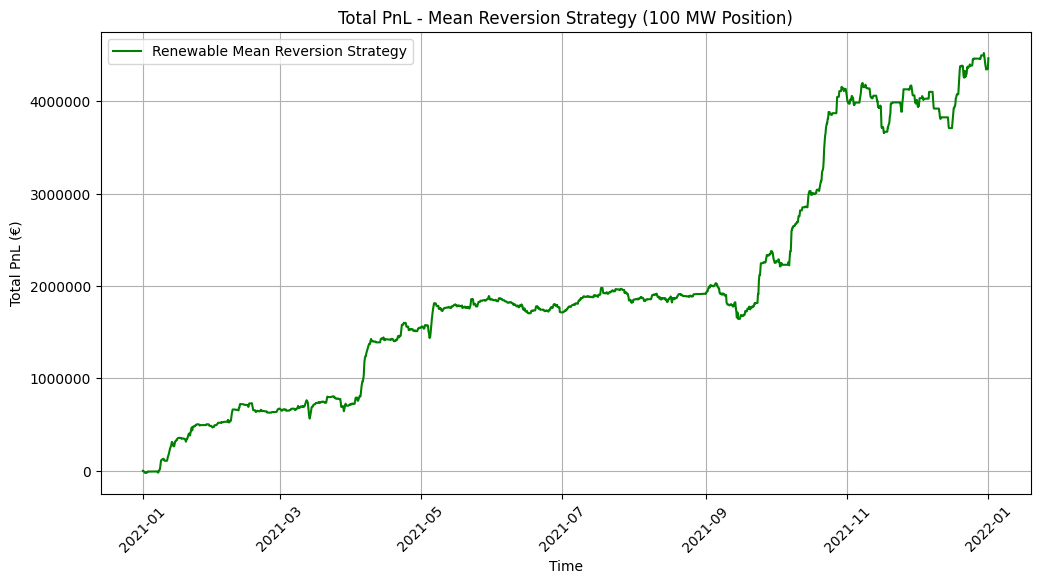

In [55]:
# Step 5 - Visualizing Profit and Loss of this strategy

plt.figure(figsize=(12, 6))
plt.plot(dataset["time"], dataset["TotalPnL"], label="Renewable Mean Reversion Strategy", color='green')
plt.ticklabel_format(style='plain', axis='y') 
plt.xlabel("Time")
plt.ylabel("Total PnL (€)")
plt.title("Total PnL - Mean Reversion Strategy (100 MW Position)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)

plt.show() 

In [56]:
# Strategy Performance Metrics
total_trades = dataset["trade_signal"].abs().sum()
total_profit = dataset["ProfitnLoss"].sum()
max_drawdown = dataset["TotalPnL"].min()
max_drawup = dataset["TotalPnL"].max()
positive_trades = (dataset["ProfitnLoss"] > 0).sum()
win_rate = (positive_trades / total_trades) * 100 if total_trades > 0 else 0
avg_trade_pnl = dataset["ProfitnLoss"].mean()

# Performance Metrics

print(f"Total Trades: {total_trades:.0F}")
print(f"Total Profit: {total_profit:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")
print(f"Positive Trades: {positive_trades:.0f}")
print(f"Win Rate: {win_rate:.2f} %")
print(f"Average Trade PnL: {avg_trade_pnl:.2f}")


Total Trades: 17518
Total Profit: 4467312.76
Max Drawdown: -24375.56
Positive Trades: 10209
Win Rate: 58.28 %
Average Trade PnL: 127.49


# Conclusion

The Mean Reversion Strategy aimed to capitalize on price misalignments between the DA market and the ID market by leveraging extreme energy production levels as trading signals. The goal was to profit from predictable market corrections when wind and solar forecasts caused overreactions in DA prices.

Why this strategy may be good: 

- Total number of trades (17,518) indicates a number of opportunities to profit
- Price corrections happen frequently, thus the 4.46 mil € profit
- Poisitive Win Rate (58.28%)
- Poisitive Trades (10209)
- High Average Trade PnL (127.49)

Why this strategy may not be good:

- Some losses may occur evident in the graph, and that requires risk management to minimze them (stop-loss, position sizing, etc.)
- If more traders start using this strategy, we might experience a market efficiency risk where opportunities for us may shrink
- Delays in execution can reduce our profitability in the ID if prices adjust too quickly 
- Using fixed percentiles for thresholds does not really account for seasonality and other market factors that may cause an impact
- This strategy does not take into account any extreme events

Overall this strategy is a good start, but it could be further built upon into something more complex that takes into account a number of different scenarios and factors. 